# A2Perf System and Reliability Metrics


In [1]:
!pip install tensorboard sns tbparse matplotlib pandas scipy seaborn tensorflow

In [2]:
import collections
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorboard as tb
import tensorflow as tf
from packaging import version
from scipy import stats

# Set some random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Set some defaults for seabron and matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.bbox'] = 'tight'


2023-11-26 20:47:46.919714: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 20:47:46.968038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 20:47:46.968085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 20:47:46.969786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 20:47:46.978680: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 20:47:46.979915: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
  "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.15.1


In [4]:
base_dir = '/home/ikechukwuu/workspace/gcs/a2perf/'
debug = False

algo_to_exp_dict = dict(
    PPO='2223',
    DDPG='2223'
)
domain = 'quadruped_locomotion'
task = 'dog_pace'

algo_to_seeds = dict(
    PPO=[
        303,
        215,
        336,
        65,
        293,
        182,
        318,
        491,
        345,
        98,
    ]
    ,
    DDPG=[
        303,
        215,
        336,
        65,
        293,
        182,
        318,
        491,
        345,
        98,
    ]
)

all_seeds_to_process = []
for algo, seeds in algo_to_seeds.items():
  all_seeds_to_process.extend(seeds)

## Reliability Metrics

In [5]:
log_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '',
                                   task)

# reduce all seeds over all algorithms to a single list

for algo in algo_to_exp_dict.keys():
  experiment_path = os.path.join(experiment_base_dir, algo.lower(),
                                 algo_to_exp_dict[algo],
                                 f'**/tensorboard/{algo.upper()}_0_1/*events*')
  print(f'Experiment Path: {experiment_path}')

  log_dirs.extend(glob.glob(experiment_path, recursive=True))

log_dirs = [log_dir for log_dir in log_dirs if
            any([f'seed_{seed}' in log_dir for seed in all_seeds_to_process])]
log_dirs

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/tensorboard/PPO_0_1/*events*
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/tensorboard/DDPG_0_1/*events*


['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_303_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1700344979.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1700436818.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_215_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1700375628.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_293_total

In [6]:
print(len(log_dirs))

20


### Pack Data into DataFrame

In [7]:
def load_tb_data(event_file):
  iterations_data = dict()
  ep_rew_data = dict()
  timestamp_data = dict()

  for event in tf.compat.v1.train.summary_iterator(event_file):
    # get the timestamp of the evnet
    timestamp = event.wall_time

    # Convert the timestamp to a datetime object
    timestamp = pd.to_datetime(timestamp, unit='s')
    timestamp_data[event.step] = timestamp

    for value in event.summary.value:
      # Check for episode_reward in the event
      if value.tag == 'episode_reward':
        if event.step in ep_rew_data:
          raise ValueError(
              f'Found duplicate episode_reward data for step: {event.step}')
        ep_rew_data[event.step] = value.simple_value

      # Check for iterations in the event
      if value.tag == 'iterations':
        if event.step in iterations_data:
          raise ValueError(
              f'Found duplicate iterations data for step: {event.step}')
        iterations_data[event.step] = value.simple_value

  df = pd.DataFrame.from_dict(iterations_data, orient='index',
                              columns=['iterations'])
  df['episode_reward'] = df['iterations'].map(ep_rew_data)
  df['timestamp'] = df['iterations'].map(timestamp_data)
  df = df.reset_index()
  df = df.rename(columns={'index': 'step'})
  df = df.drop(columns=['iterations'])
  df['step'] = df['step'].astype(np.int32)
  return df


In [13]:
all_df = pd.DataFrame()
for log_dir in log_dirs:
  print(log_dir)
  log_base_dir = os.path.dirname(log_dir)
  exp_split = log_dir.split('/')

  exp_name = exp_split[-4]
  exp_name_split = exp_name.split('_')

  seed = int(exp_name_split[-5])
  experiment = exp_split[-5]
  algo = exp_split[-6]
  if seed not in algo_to_seeds[algo.upper()]:
    print(f'\tSkipping {log_dir} since seed {seed} is not in algo_to_seeds')
    continue

  print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

  if os.path.exists(os.path.join(log_base_dir, 'data.csv')):
    print(f'\tSkipping {log_dir} since data.csv already exists')
    data = pd.read_csv(os.path.join(log_base_dir, 'data.csv'))
  else:
    data = load_tb_data(log_dir)

    # Convert datetime columns to offset-naive (if they exist and are offset-aware)
    # Example: assuming 'timestamp' is your datetime column
    if 'timestamp' in data.columns:
      data['timestamp'] = pd.to_datetime(data['timestamp']).apply(
          lambda x: x.replace(tzinfo=None) if x.tzinfo else x)

    data['seed'] = seed
    data['experiment'] = experiment
    data['algo'] = algo
    data['algo'] = data['algo'].str.upper()

    print(f'\tSaving data.csv to {log_base_dir}')
    data.to_csv(os.path.join(log_base_dir, 'data.csv'))

  print(f'\tFinished processing {log_dir}')
  print(f'\tNumber of rows: {len(data)}')

  # Print out the last global step value
  print(f'\tLast global step value: {data["step"].iloc[-1]}')
  all_df = pd.concat([all_df, data])

all_df['timestamp'] = pd.to_datetime(all_df['timestamp']).apply(
    lambda x: x.replace(tzinfo=None) if x.tzinfo else x)


/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_303_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1700344979.locomotion-0
Processing Experiment: 2223, Seed: 303, Algo: ppo
	Skipping /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_303_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1700344979.locomotion-0 since data.csv already exists
	Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_303_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1700344979.locomotion-0
	Number of rows: 47059
	Last global step value: 47058
/home/ikechukwuu/workspace/gcs/

In [14]:
for algo in algo_to_exp_dict.keys():
  algo_df = all_df[all_df['algo'] == algo]
  print(f'Algo: {algo}, Number of rows: {len(algo_df)}')

  # also get number of seeds
  print(f'Number of seeds: {len(algo_df["seed"].unique())}')


Algo: PPO, Number of rows: 470590
Number of seeds: 10
Algo: DDPG, Number of rows: 467840
Number of seeds: 10


In [15]:
for algo in algo_to_exp_dict.keys():
  df = all_df[all_df['algo'] == algo]
  print(f'Algo: {algo}')
  for seed, group in df.groupby('seed'):
    print(f'\tSeed: {seed}')
    diff = group['step'].diff()
    print(f'\t\tMin diff: {diff.min()}')
    print(f'\t\tMax diff: {diff.max()}')
    print(f'\t\tMedian diff: {diff.median()}')
    print(f'\t\tMean diff: {diff.mean()}')

Algo: PPO
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 182
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 215
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 293
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 303
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 318
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 336
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 345
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 491
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
Algo: DDPG
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 182
		Min diff: 1.0
		Max di

### Variations in Plotting

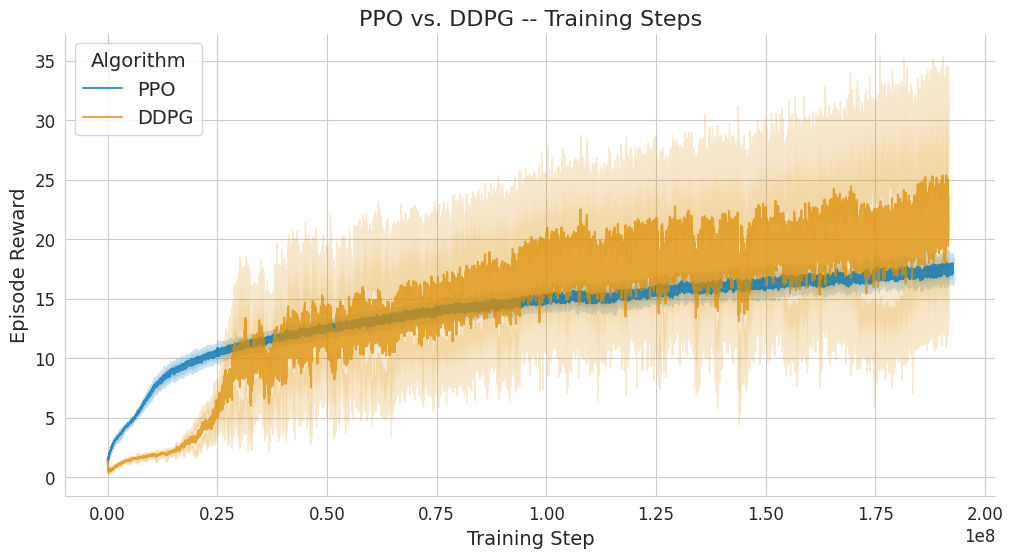

In [16]:
# Assuming all_df is your DataFrame
all_df['algo'] = all_df['algo'].str.upper()  # Capitalize the 'algo' column
step_to_plot = all_df['step'] * 4096  # Multiply the 'step' column by 4096

# Plot the data
axes = sns.lineplot(x=step_to_plot, y='episode_reward', hue='algo', data=all_df,
                    errorbar='sd', palette='colorblind', )

for line in axes.lines:
  line.set_alpha(0.75)

# Set the labels and titles
axes.set_xlabel('Training Step', fontsize=14)
axes.set_ylabel('Episode Reward', fontsize=14)
axes.set_title('PPO vs. DDPG -- Training Steps', fontsize=16)

# Improve the legend
axes.legend(title='Algorithm', loc='upper left', fontsize='medium')

sns.despine()

# Show the plot
plt.show()

In [17]:
# We need to align the plots by duration, otherwise the plots will be misaligned
# We can do this by finding the minimum timestamp for each algo and subtracting it from all timestamps

# this needs to be done for each algo and seed
for algo, group in all_df.groupby(['algo', 'seed']):
  min_timestamp = group['timestamp'].min()
  all_df.loc[(all_df['algo'] == algo[0]) & (all_df['seed'] == algo[1]),
  'timestamp_adjusted'] = group['timestamp'] - min_timestamp

In [18]:
# Now replace the datetimes in timestamp adjusted with td.seconds of that datetime
all_df['timestamp_adjusted'] = all_df['timestamp_adjusted'].apply(
    lambda x: x.seconds)

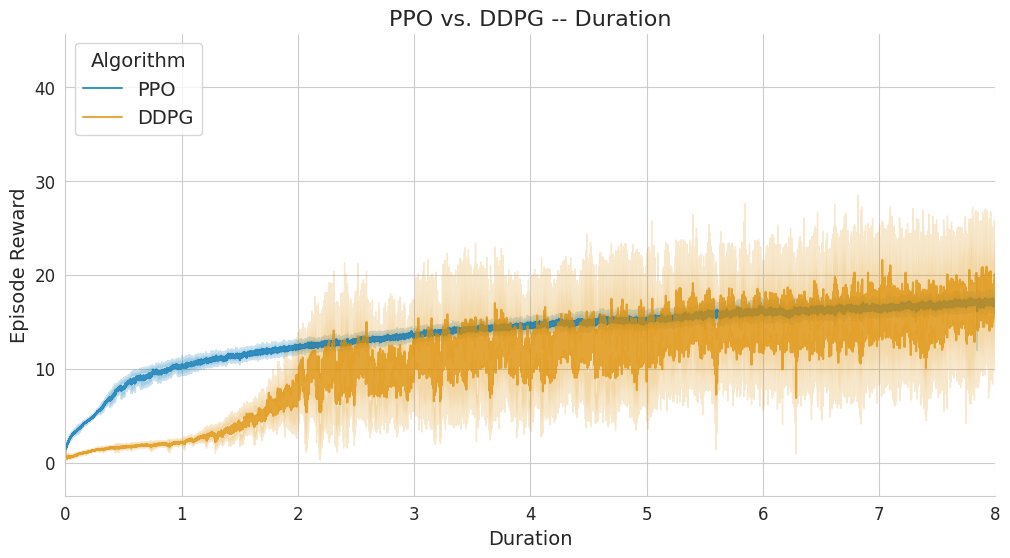

In [19]:
plt.figure(figsize=(12, 6))
step_to_plot = all_df['timestamp_adjusted'] / 3600  # Convert to hours
# Plot the data
axes = sns.lineplot(x=step_to_plot, y='episode_reward', hue='algo', data=all_df,
                    errorbar='sd', palette='colorblind', )

for line in axes.lines:
  line.set_alpha(0.75)

# Set the labels and titles
axes.set_xlabel('Duration', fontsize=14)
axes.set_ylabel('Episode Reward', fontsize=14)
axes.set_title('PPO vs. DDPG -- Duration', fontsize=16)

# Improve the legend
axes.legend(title='Algorithm', loc='upper left', fontsize='medium')

# Fine-tuning for professional appearance
axes.tick_params(labelsize=12)
sns.despine()

# Stop the plot at 8 hours
axes.set_xlim(0, 8)
# Show the plot
plt.show()

### Determining the score thresholds for difficulties

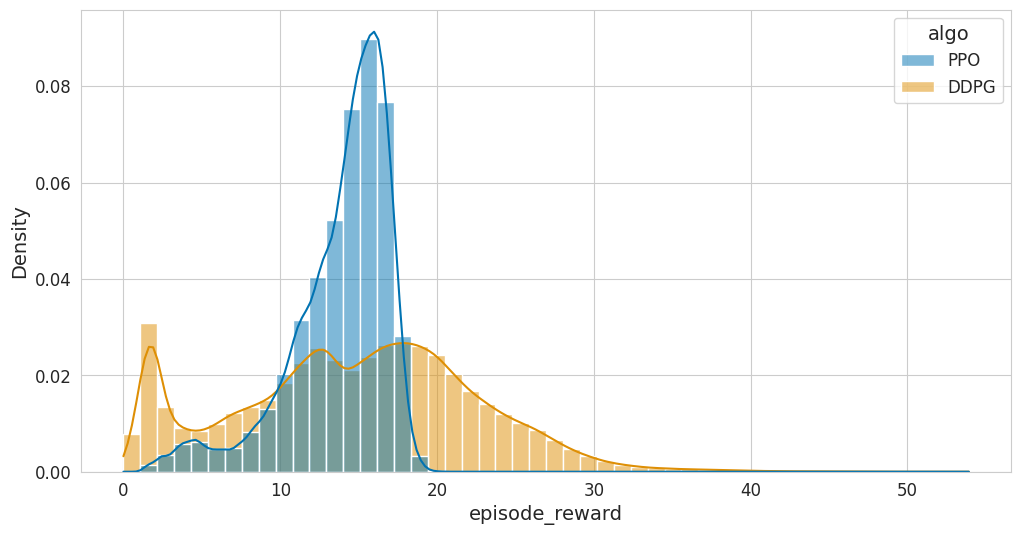

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
axes = sns.histplot(data=all_df, x='episode_reward', hue='algo', bins=50,
                    palette='colorblind', kde=True, stat='density')


/tmp/ipykernel_1152805/937052698.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  axes = sns.histplot(data=all_df, x='episode_reward', bins=50,


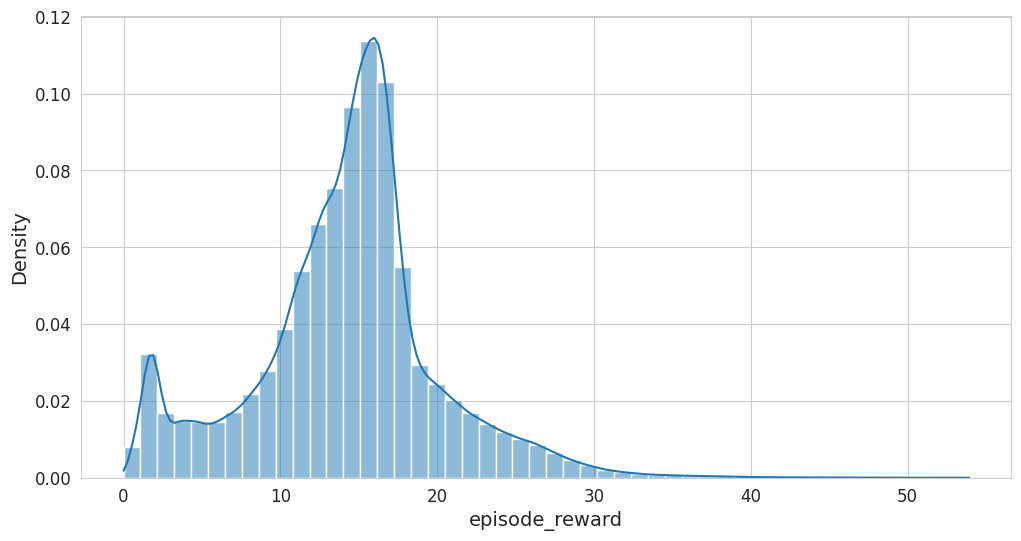

In [21]:
# Now plot the combined density plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
axes = sns.histplot(data=all_df, x='episode_reward', bins=50,
                    palette='colorblind', kde=True, stat='density')

In [22]:
mean_reward = all_df['episode_reward'].mean()
std_reward = all_df['episode_reward'].std()

# We want the novice scores to be the bottom standard deviation
# We want the expert scores to be the top standard deviation
# We want the intermediate scores to be +/- 1 standard deviation

# For novice, take the lowest score and add 1 standard deviation
# novice_upper_bound = all_df['episode_reward'].min() + std_reward

# For expert, take the highest score and subtract 1 standard deviation
# expert_lower_bound = all_df['episode_reward'].max() - std_reward

# For intermediate, take the mean score and add/subtract 1 standard deviation
# intermediate_lower_bound = mean_reward - std_reward
# intermediate_upper_bound = mean_reward + std_reward

# Let's try something else. Let's take novice as 2 standard deviations below the mean, and expert as 2 standard deviations above the mean. So that means we should have approx. 95% of the data in the intermediate range, but we'll tighten that up later.
# all assuming that the episode rewards are normally distributed
novice_upper_bound = mean_reward - (2 * std_reward)
expert_lower_bound = mean_reward + (2 * std_reward)

# For intermediate, take the mean score and add/subtract 1 standard deviation
intermediate_lower_bound = mean_reward - std_reward
intermediate_upper_bound = mean_reward + std_reward

novice_score_bounds = (-np.inf, novice_upper_bound)
intermediate_score_bounds = (intermediate_lower_bound, intermediate_upper_bound)
expert_score_bounds = (expert_lower_bound, np.inf)

print(f'Novice Score Bounds: {novice_score_bounds}')
print(f'Intermediate Score Bounds: {intermediate_score_bounds}')
print(f'Expert Score Bounds: {expert_score_bounds}')


Novice Score Bounds: (-inf, 2.431718375770952)
Intermediate Score Bounds: (8.3368632329224, 20.147152947225297)
Expert Score Bounds: (26.052297804376746, inf)


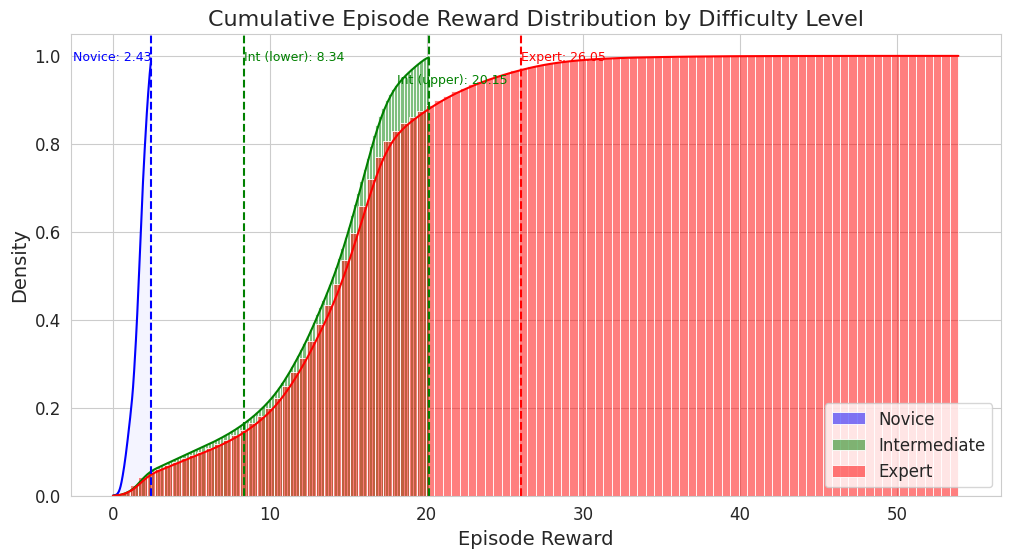

In [23]:
# Plotting
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
axes = plt.gca()

# Define colors for each difficulty level
colors = {'novice': 'blue', 'intermediate': 'green', 'expert': 'red'}

# Plot cumulative histograms
sns.histplot(all_df[all_df['episode_reward'] <= novice_upper_bound],
             x='episode_reward', bins=100, color=colors['novice'], kde=True,
             stat='density', ax=axes, label='Novice', cumulative=True)
sns.histplot(all_df[all_df['episode_reward'] <= intermediate_upper_bound],
             x='episode_reward', bins=100, color=colors['intermediate'],
             kde=True, stat='density', ax=axes, label='Intermediate',
             cumulative=True)
sns.histplot(all_df, x='episode_reward', bins=100, color=colors['expert'],
             kde=True, stat='density', ax=axes, label='Expert', cumulative=True)

# Add vertical lines for boundaries
axes.axvline(novice_upper_bound, ls='--', color=colors['novice'])
axes.axvline(intermediate_lower_bound, ls='--', color=colors['intermediate'])
axes.axvline(intermediate_upper_bound, ls='--', color=colors['intermediate'])
axes.axvline(expert_lower_bound, ls='--', color=colors['expert'])

# Add text for the boundaries
axes.text(novice_upper_bound, axes.get_ylim()[1] * 0.95,
          f'Novice: {novice_upper_bound:.2f}', ha='right', va='center',
          color=colors['novice'], fontsize=9)
axes.text(intermediate_lower_bound, axes.get_ylim()[1] * 0.95,
          f'Int (lower): {intermediate_lower_bound:.2f}', ha='left',
          va='center', color=colors['intermediate'], fontsize=9)
axes.text(intermediate_upper_bound * 0.9, axes.get_ylim()[1] * 0.9,
          f'Int (upper): {intermediate_upper_bound:.2f}', ha='left',
          va='center', color=colors['intermediate'], fontsize=9)
axes.text(expert_lower_bound, axes.get_ylim()[1] * 0.95,
          f'Expert: {expert_lower_bound:.2f}', ha='left', va='center',
          color=colors['expert'], fontsize=9)

# Set labels and title
axes.set_xlabel('Episode Reward', fontsize=14)
axes.set_ylabel('Density', fontsize=14)
axes.set_title('Cumulative Episode Reward Distribution by Difficulty Level',
               fontsize=16)

# Add a legend
axes.legend()

plt.show()


In [24]:
levels_df = pd.DataFrame()

for algo in algo_to_exp_dict.keys():
  policies_path = os.path.join(experiment_base_dir, algo.lower(),
                               algo_to_exp_dict[algo.upper()],
                               f'**/policies/*_steps.zip')
  policies_paths = glob.glob(policies_path, recursive=True)

  policy_path_df = pd.DataFrame(policies_paths, columns=['path'])
  policy_path_df['step'] = policy_path_df['path'].str.extract(
      r'(\d+)_steps.zip', expand=False).astype(np.int32)
  policy_path_df['step'] = policy_path_df['step'] // 4096
  policy_path_df = policy_path_df.sort_values(by='step')
  policy_path_df['algo'] = algo.upper()
  policy_path_df['experiment'] = policy_path_df['path'].str.split('/').str[-4]
  policy_path_df['seed'] = \
    policy_path_df['path'].str.split('/').str[-3].str.split('_').str[-5].astype(
        np.int32)

  # Now we can simply inner join with the all_df dataframe to get the score at each step

  policy_path_df = policy_path_df.merge(
      all_df[['step', 'episode_reward', 'seed', 'algo', 'timestamp']],
      on=['step', 'seed', 'algo'], how='inner')

  # ADd a 'level' column to the policy_path_df
  policy_path_df['level'] = 'expert'

  # now label the policies as novice, intermediate, or expert
  policy_path_df.loc[
    policy_path_df['episode_reward'].between(
        *novice_score_bounds), 'level'] = 'novice'
  policy_path_df.loc[
    policy_path_df['episode_reward'].between(*intermediate_score_bounds),
    'level'] = 'intermediate'
  policy_path_df.loc[
    policy_path_df['episode_reward'].between(
        *expert_score_bounds), 'level'] = 'expert'
  levels_df = pd.concat([levels_df, policy_path_df])



In [57]:
# Instead of simply choosing the top policiies, let's choose random policies from each level
NUM_POLICIES_PER_LEVEL = 50
policies_for_data_generation_df = (levels_df.groupby('level')
                                   .apply(
    lambda x: x.sample(NUM_POLICIES_PER_LEVEL))
                                   .reset_index(drop=True))
# print head but include the index. for some reason the algo column is not showing up


# Let's choose the top policies from each level
# policies_for_data_generation_df = (levels_df.groupby('level')
#                                    .apply(
#     lambda x: x.nlargest(NUM_POLICIES_PER_LEVEL, 'episode_reward'))
#                                    .reset_index(drop=True))
print(policies_for_data_generation_df.head(NUM_POLICIES_PER_LEVEL))

                                                 path   step  algo experiment  \
0   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...  20112  DDPG       2223   
1   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...   2439   PPO       2223   
2   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...   9320  DDPG       2223   
3   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...  35564  DDPG       2223   
4   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...   8339  DDPG       2223   
5   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...  33356  DDPG       2223   
6   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...  41941  DDPG       2223   
7   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...  35809  DDPG       2223   
8   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...   3924  DDPG       2223   
9   /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...  39978  DDPG       2223   
10  /home/ikechukwuu/workspace/gcs/a2perf/quadrupe...  36299  DDPG       2223   
11  /home/ikechukwuu/workspa

In [58]:
SKILL_LEVEL_TO_POLICY_STEP = collections.defaultdict(list)
for algo in algo_to_exp_dict.keys():
  for level in ('novice', 'intermediate', 'expert'):
    level_paths = policies_for_data_generation_df[
      (policies_for_data_generation_df['algo'] == algo) & (
          policies_for_data_generation_df['level'] == level)][
      'path'].tolist()
    SKILL_LEVEL_TO_POLICY_STEP[level].extend(level_paths)

# Now merge the various difficulty level policies into a dictionary with keys for each level
print(SKILL_LEVEL_TO_POLICY_STEP)
''

defaultdict(<class 'list'>, {'novice': ['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/policies/rl_policy_4250_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_182_total_env_steps_200000000/policies/rl_policy_4250_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_293_total_env_steps_200000000/policies/rl_policy_4250_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_345_total_env_steps_200000000/policies/rl_policy_4250_steps.zip

''

### Computing Window Size

In [27]:
EVAL_POINTS_PER_WINDOW = 5
med_step_diffs = []
for algo in algo_to_exp_dict.keys():
  algo = algo.upper()
  algo_df = all_df[all_df['algo'] == algo]
  algo_grouped = algo_df.groupby('seed')
  for seed, group in algo_grouped:
    mean_step_diff = group['step'].diff().mean()
    median_step_diff = group['step'].diff().median()
    window_size = int(EVAL_POINTS_PER_WINDOW * median_step_diff)
    print(f'Seed: {seed}')
    print(f'\tMean step difference: {mean_step_diff}')
    print(f'\tMedian step difference: {median_step_diff}')
    print(f'\tWindow size: {window_size}')
    med_step_diffs.append(median_step_diff)

Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 182
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 215
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 293
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 303
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 318
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 336
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 345
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 491
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 182
	Mean step

In [28]:
window_size = int(EVAL_POINTS_PER_WINDOW * np.mean(med_step_diffs))
avg_step_diff = int(np.mean(med_step_diffs))
window_size, avg_step_diff

(5, 1)

### Computing Reliability Metrics

In [29]:
eval_points = list(
    range(np.ceil(window_size / 2).astype(int), max(all_df['step']),
          avg_step_diff))
eval_points


[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


In [30]:
all_training_metrics = collections.defaultdict(dict)

In [31]:
window_fn = stats.iqr

for algo in algo_to_exp_dict.keys():
  all_iqr_values = []
  number_valid_eval_points = []
  seeds_to_process = algo_to_seeds[algo]
  print(f'Processing algo: {algo}')
  algo_filtered_df = all_df[all_df['algo'] == algo]
  for seed in seeds_to_process:
    windows_to_evaluate = []
    print(f'\tProcessing seed: {seed}')
    seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == seed].copy()
    seed_filtered_df['episode_reward_diff'] = seed_filtered_df[
      'episode_reward'].diff()
    seed_filtered_df = seed_filtered_df[['step', 'episode_reward_diff']]
    seed_filtered_df = seed_filtered_df.dropna()
    print('\t\tNumber of rows: ', len(seed_filtered_df))
    steps, episode_reward_diff = seed_filtered_df.to_numpy().T
    for eval_point in eval_points:
      low_end = np.ceil(eval_point - (window_size / 2))
      high_end = np.floor(eval_point + (window_size / 2))

      eval_points_above = steps >= low_end
      eval_points_below = steps <= high_end
      eval_points_in_window = np.logical_and(eval_points_above,
                                             eval_points_below)
      valid_eval_points = np.nonzero(eval_points_in_window)[0]

      if len(valid_eval_points) == 0:
        # print(f'\t\tNo valid eval points for eval point: {eval_point}')
        # print(f'Stopping since that means current seed is done')
        break

      number_valid_eval_points.append(len(valid_eval_points))
      windows_to_evaluate.append(valid_eval_points)
    iqr_values = [window_fn(episode_reward_diff[window]) for window in
                  windows_to_evaluate]
    all_iqr_values.extend(iqr_values)
    # print(f'\t\tOn average there were {np.mean(number_valid_eval_points)} valid eval points per window')
    # print(f'\t\tMean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
    # print(f'\t\tMedian IQR: {median_iqr}')

  all_training_metrics[algo]['iqr'] = dict(
      mean=np.mean(all_iqr_values),
      std=np.std(all_iqr_values)
  )
  print(
      f'\tAll mean iqr values: {np.mean(all_iqr_values)} +/- {np.std(all_iqr_values)}')


Processing algo: PPO
	Processing seed: 303
		Number of rows:  47058
	Processing seed: 215
		Number of rows:  47058
	Processing seed: 336
		Number of rows:  47058
	Processing seed: 65
		Number of rows:  47058
	Processing seed: 293
		Number of rows:  47058
	Processing seed: 182
		Number of rows:  47058
	Processing seed: 318
		Number of rows:  47058
	Processing seed: 491
		Number of rows:  47058
	Processing seed: 345
		Number of rows:  47058
	Processing seed: 98
		Number of rows:  47058
	All mean iqr values: 0.6406753871007929 +/- 0.4358594855444334
Processing algo: DDPG
	Processing seed: 303
		Number of rows:  46783
	Processing seed: 215
		Number of rows:  46783
	Processing seed: 336
		Number of rows:  46783
	Processing seed: 65
		Number of rows:  46783
	Processing seed: 293
		Number of rows:  46783
	Processing seed: 182
		Number of rows:  46783
	Processing seed: 318
		Number of rows:  46783
	Processing seed: 491
		Number of rows:  46783
	Processing seed: 345
		Number of rows:  46783
	Pr


##### Long-term risk across time
Long - term risk across time represents the propensity of the agent to crash after achieving a higher performance measure

In [32]:
def compute_drawdown(sequence):
  """Computes the drawdown for a sequence of numbers.

    The drawdown at time T is the decline from the highest peak occurring at or
    before time T. https://en.wikipedia.org/wiki/Drawdown_(economics).

    The drawdown is always non-negative. A larger (more positive) drawdown
    indicates a larger drop.

  Args:
    sequence: A numpy array.

  Returns:
    A numpy array of same length as the original sequence, containing the
      drawdown at each timestep.
  """
  peak_so_far = np.maximum.accumulate(sequence)
  return peak_so_far - sequence

In [33]:
alpha = 0.95

for algo in algo_to_exp_dict.keys():
  all_cvars = []
  all_drawdowns = []
  print(f'Processing algo: {algo}')
  algo_filtered_df = all_df[all_df['algo'] == algo]
  seeds_to_process = algo_to_seeds[algo]
  for seed in seeds_to_process:
    print(f'\tProcessing seed: {seed}')

    seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == seed].copy()
    seed_filtered_df = seed_filtered_df.sort_values(by='step')
    # Compute the drawdowns
    episode_rewards = seed_filtered_df['episode_reward'].values
    drawdowns = compute_drawdown(episode_rewards)
    all_drawdowns.extend(drawdowns)

    # Get the bottom "alpha" percent of drawdowns (we use the 95th percentile to get the bottom 5% of drawdowns)
    top_alpha_percent = np.percentile(drawdowns, alpha * 100)

    # CVaR is the average of the bottom "alpha" percent of drawdowns
    # cvar = np.mean(drawdowns[drawdowns <= bottom_alpha_percent]) we actually need greater than
    cvar = np.mean(drawdowns[drawdowns >= top_alpha_percent])
    all_cvars.append(cvar)
    print(f'\t\tCVaR: {cvar}')

  #now show overall mean and std of all cvars
  print(f'\tAll CVaR values: {all_cvars}')
  print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')
  all_training_metrics[algo]['long_term_risk'] = dict(
      mean=np.mean(all_cvars),
      std=np.std(all_cvars)
  )
  # now compute the cvar of all drawdowns together
  all_drawdowns = np.array(all_drawdowns)
  top_alpha_percent = np.percentile(all_drawdowns, alpha * 100)
  cvar = np.mean(all_drawdowns[all_drawdowns >= top_alpha_percent])
  print(f'\tAll CVaR values: {cvar}')

Processing algo: PPO
	Processing seed: 303
		CVaR: 3.3662699023764335
	Processing seed: 215
		CVaR: 2.989862638587806
	Processing seed: 336
		CVaR: 3.4639808226786823
	Processing seed: 65
		CVaR: 3.0920427020843406
	Processing seed: 293
		CVaR: 3.304971417314796
	Processing seed: 182
		CVaR: 2.9125143035746
	Processing seed: 318
		CVaR: 3.1407271205644323
	Processing seed: 491
		CVaR: 3.0087966233985837
	Processing seed: 345
		CVaR: 3.097666996567998
	Processing seed: 98
		CVaR: 3.1353497507214487
	All CVaR values: [3.3662699023764335, 2.989862638587806, 3.4639808226786823, 3.0920427020843406, 3.304971417314796, 2.9125143035746, 3.1407271205644323, 3.0087966233985837, 3.097666996567998, 3.1353497507214487]
	Average CVaR value: 3.151218227786912 +/- 0.166654780578371
	All CVaR values: 3.1834130707468016
Processing algo: DDPG
	Processing seed: 303
		CVaR: 9.086317928071715
	Processing seed: 215
		CVaR: 22.99282658049184
	Processing seed: 336
		CVaR: 17.689304072454444
	Processing seed: 6

##### Short-term risk across time
Short - term risk across time represents how volatile the agent is from eval point to eval point

In [34]:
alpha = 0.05
for algo in algo_to_exp_dict.keys():
  all_cvars = []
  all_diffs = []
  print(f'Processing algo: {algo}')
  algo_filtered_df = all_df[all_df['algo'] == algo]
  seeds_to_process = algo_to_seeds[algo]
  for seed in seeds_to_process:
    print(f'\tProcessing seed: {seed}')

    seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == seed].copy()
    seed_filtered_df = seed_filtered_df.sort_values(by='step')

    seed_filtered_df['episode_reward_diff'] = seed_filtered_df[
      'episode_reward'].diff()
    seed_filtered_df = seed_filtered_df.dropna()

    episode_reward_diffs = seed_filtered_df['episode_reward_diff'].values
    all_diffs.extend(episode_reward_diffs)
    bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100,
                                         interpolation='linear')

    # CVaR is the average of the bottom "alpha" percent of diffs
    # cvar = np.mean(drawdowns[drawdowns <= top_alpha_percent])
    cvar = np.mean(
        episode_reward_diffs[episode_reward_diffs <= bottom_alpha_percent])
    all_cvars.append(cvar)
    print(f'\t\tCVaR: {cvar}')

  # Finally, report the mean and standard deviation of ALL the CVaR values in \pm notation
  print(f'\tAll CVaR values: {all_cvars}')
  print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')
  all_training_metrics[algo]['short_term_risk'] = dict(
      mean=np.mean(all_cvars),
      std=np.std(all_cvars)
  )

  # now compute the cvar of all diffs together
  all_diffs = np.array(all_diffs)
  bottom_alpha_percent = np.percentile(all_diffs, alpha * 100,
                                       interpolation='linear')
  cvar = np.mean(all_diffs[all_diffs <= bottom_alpha_percent])
  print(f'\tAll CVaR values: {cvar}')

Processing algo: PPO
	Processing seed: 303
		CVaR: -1.3231608102638772
	Processing seed: 215
		CVaR: -1.218599901268242
	Processing seed: 336
		CVaR: -1.3431166058340531
	Processing seed: 65
		CVaR: -1.2260720191790204
	Processing seed: 293
		CVaR: -1.2997725353411194
	Processing seed: 182
		CVaR: -1.21151236377267
	Processing seed: 318
		CVaR: -1.3295862783131274
	Processing seed: 491
		CVaR: -1.238573464240817
	Processing seed: 345
		CVaR: -1.2879463764033416
	Processing seed: 98
		CVaR: -1.273138004518599
	All CVaR values: [-1.3231608102638772, -1.218599901268242, -1.3431166058340531, -1.2260720191790204, -1.2997725353411194, -1.21151236377267, -1.3295862783131274, -1.238573464240817, -1.2879463764033416, -1.273138004518599]
	Average CVaR value: -1.275147835913487 +/- 0.04653603331057103


/tmp/ipykernel_1152805/1671589856.py:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100,
/tmp/ipykernel_1152805/1671589856.py:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100,
/tmp/ipykernel_1152805/1671589856.py:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method th

	All CVaR values: -1.2769236091629335
Processing algo: DDPG
	Processing seed: 303
		CVaR: -3.8262518818816567
	Processing seed: 215
		CVaR: -10.48599547320961
	Processing seed: 336
		CVaR: -7.785067799560025
	Processing seed: 65
		CVaR: -13.175864986986177
	Processing seed: 293
		CVaR: -6.696524645069726
	Processing seed: 182
		CVaR: -10.220729517376322
	Processing seed: 318
		CVaR: -6.93545971691099
	Processing seed: 491
		CVaR: -8.74776063986823
	Processing seed: 345
		CVaR: -10.99910357186937
	Processing seed: 98
		CVaR: -6.250827555065481
	All CVaR values: [-3.8262518818816567, -10.48599547320961, -7.785067799560025, -13.175864986986177, -6.696524645069726, -10.220729517376322, -6.93545971691099, -8.74776063986823, -10.99910357186937, -6.250827555065481]
	Average CVaR value: -8.512358578779759 +/- 2.6112892215177657
	All CVaR values: -9.242292702269374


/tmp/ipykernel_1152805/1671589856.py:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100,
/tmp/ipykernel_1152805/1671589856.py:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100,
/tmp/ipykernel_1152805/1671589856.py:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method th


##### Risk across runs
Risk across runs tells use how poor the final performance of the worst runs are

In [35]:
# Get the final episode reward for each seed
final_episode_rewards = all_df.groupby(['algo', 'seed']).tail(1)
final_episode_rewards

,Unnamed: 0,step,episode_reward,timestamp,seed,experiment,algo,timestamp_adjusted
47058,47058,47058,17.183769,2023-11-19 06:32:03.685459712,303,2223,PPO,30538
47058,47058,47058,16.957911,2023-11-20 07:24:16.406444544,65,2223,PPO,28234
47058,47058,47058,16.846550,2023-11-19 15:01:25.814547456,215,2223,PPO,30453
47058,47058,47058,16.636124,2023-11-19 06:14:41.344634624,293,2223,PPO,29475
47058,47058,47058,17.580492,2023-11-19 14:48:48.945184768,345,2223,PPO,30703
47058,47058,47058,16.931946,2023-11-19 15:00:01.619083008,182,2223,PPO,31406
47058,47058,47058,17.546648,2023-11-19 23:22:20.251298560,98,2223,PPO,30700
47058,47058,47058,17.220922,2023-11-19 23:25:23.268020992,318,2223,PPO,30207
47058,47058,47058,16.022621,2023-11-19 06:15:15.472755200,491,2223,PPO,29501
47058,47058,47058,19.192085,2023-11-19 23:31:50.798664960,336,2223,PPO,30514


In [36]:
# Compute the CVaR of final episode rewards for each algo
alpha = 0.05
for algo in algo_to_exp_dict.keys():
  algo_final_episode_rewards = final_episode_rewards[
    final_episode_rewards['algo'] == algo]
  top_alpha_percent = np.percentile(
      algo_final_episode_rewards['episode_reward'].values, alpha * 100,
      interpolation='linear')
  cvar = np.mean(algo_final_episode_rewards['episode_reward'].values[
                   algo_final_episode_rewards[
                     'episode_reward'].values <= top_alpha_percent])
  print(f'Algo: {algo}, CVaR: {cvar}')
  all_training_metrics[algo]['risk_across_runs'] = cvar,


Algo: PPO, CVaR: 16.022621154785156
Algo: DDPG, CVaR: 13.111123085021973


/tmp/ipykernel_1152805/1960041116.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  top_alpha_percent = np.percentile(



#### Dispersion across runs


In [37]:
def lowpass_filter(curve, lowpass_thresh):
  filt_b, filt_a = scipy.signal.butter(8, lowpass_thresh)

  def butter_filter_fn(c):
    padlen = min(len(c) - 1, 3 * max(len(filt_a), len(filt_b)))
    return scipy.signal.filtfilt(filt_b, filt_a, curve, padlen=padlen)

  processed_curve = butter_filter_fn(curve)
  return processed_curve


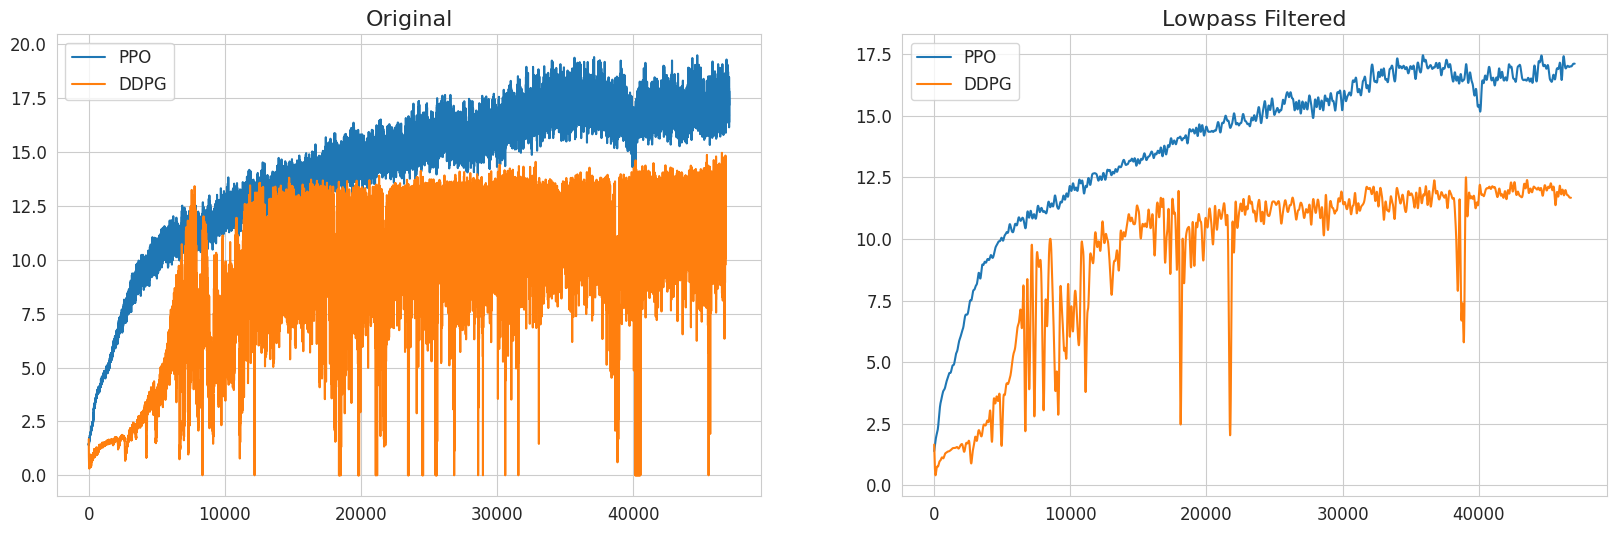

In [38]:
# Plot the first curve before and after lowpass filtering
# curve = ep_rew_clean[ep_rew_clean['seed'] == '37']['value'].values
# lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)

ppo_curve = all_df[(all_df['algo'] == 'PPO') & (all_df['seed'] == 303)][
  'episode_reward'].values

ddpg_curve = all_df[(all_df['algo'] == 'DDPG') & (all_df['seed'] == 303)][
  'episode_reward'].values

low_pass_ppo_curve = lowpass_filter(ppo_curve, lowpass_thresh=0.01)
low_pass_ddpg_curve = lowpass_filter(ddpg_curve, lowpass_thresh=0.01)

# plot both curves with the original on the left, and lowpass on the right
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(ppo_curve)
axes[0].plot(ddpg_curve)
axes[0].set_title('Original')
axes[1].plot(low_pass_ppo_curve)
axes[1].plot(low_pass_ddpg_curve)
axes[1].set_title('Lowpass Filtered')

#add a legend so it's easy to read
axes[0].legend(['PPO', 'DDPG'])
axes[1].legend(['PPO', 'DDPG'])


In [39]:
# For each algo, compute a new df with the lowpass filtered curves
lowpass_df = pd.DataFrame()
for algo in algo_to_exp_dict.keys():
  algo_df = all_df[all_df['algo'] == algo]
  for seed, group in algo_df.groupby('seed'):
    curve = group['episode_reward'].values
    lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)
    group['lowpass_episode_reward'] = lowpass_curve
    lowpass_df = pd.concat([lowpass_df, group])

<Axes: xlabel='step', ylabel='lowpass_episode_reward'>

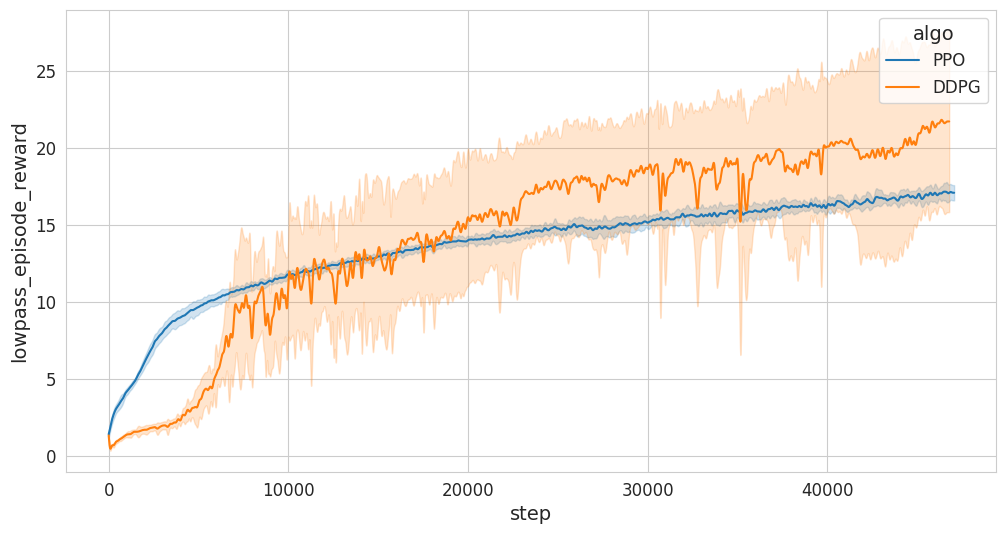

In [40]:
# plot both algorithms but group by the seeds to get mean and standard deviation
sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo', data=lowpass_df,
             errorbar='sd')

Text(0, 2.431718375770952, '2.43')

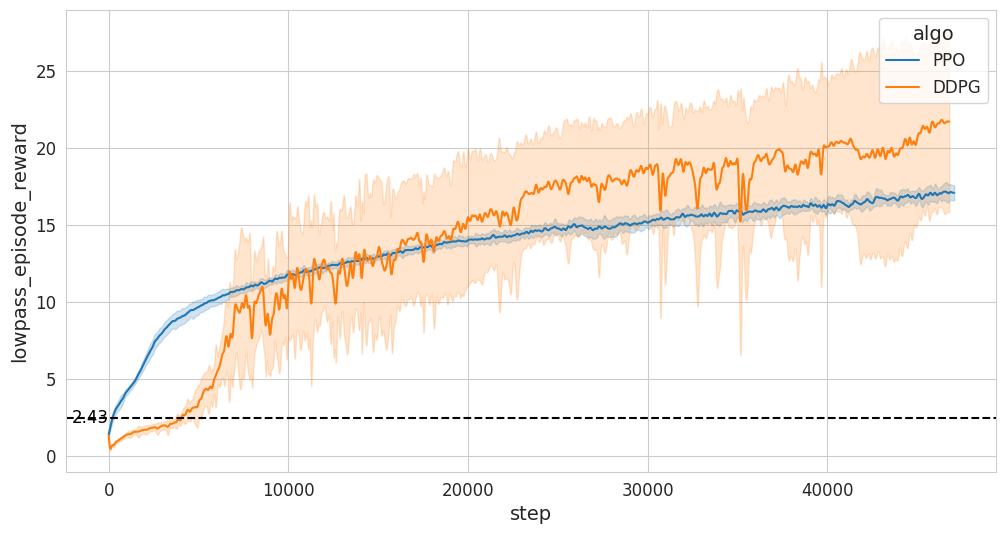

In [41]:
x = sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo',
                 data=lowpass_df, errorbar='sd')
# for 
#   draw horizontal lines and label the score thresholds
# x.axhline(loc, ls='--', color='black')
# x.text(0, loc, f'{loc:.2f}', ha='right', va='center', color='black',
#        fontsize=12)

# Draw horizontal lines to show the expertise levels
x.axhline(novice_upper_bound, ls='--', color='black')
x.text(0, novice_upper_bound, f'{novice_upper_bound:.2f}', ha='right',
       va='center', color='black',
       fontsize=12)


In [42]:
for algo in algo_to_exp_dict.keys():
  algo_df = lowpass_df[lowpass_df['algo'] == algo]
  seeds_to_process = algo_to_seeds[algo]
  # These computations are for dispersion ACROSS runs. We simply need to group by step and then compute the IQR
  # of the episode rewards at each step

  # First examine the group to make sure we get the same number of values as the number of seeds
  for step, group in algo_df.groupby('step'):
    assert len(group) == len(
        seeds_to_process), f'Expected {len(seeds_to_process)} values but got {len(group)}'

  # Now compute the IQR of the episode rewards at each step
  iqr_values = algo_df.groupby('step')['lowpass_episode_reward'].apply(
      stats.iqr)
  mean_iqr = iqr_values.mean()
  print(f'Algo: {algo}, Mean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
  all_training_metrics[algo]['dispersion_across_runs'] = dict(
      mean=mean_iqr,
      std=np.std(iqr_values)
  )

Algo: PPO, Mean IQR: 0.4608676592465547 +/- 0.17096782814963507
Algo: DDPG, Mean IQR: 4.298872195852825 +/- 1.8586538578039606


## System Metrics

In [43]:
# Load all of the system metrics using glob and pandas csv

system_metric_dirs = []

for algo in algo_to_exp_dict.keys():
  experiment_path = os.path.join(experiment_base_dir, algo.lower(),
                                 algo_to_exp_dict[algo],
                                 f'**/train_emissions.csv')
  print(f'Experiment Path: {experiment_path}')

  system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv


In [44]:
len(system_metric_dirs)

20

In [45]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
  split_dir = metric_dir.split('/')
  exp_name = split_dir[-3]
  exp_name_split = exp_name.split('_')
  print(exp_name_split)
  seed = exp_name_split[-5]
  experiment = split_dir[-4]
  algo = split_dir[-5]
  algo = algo.upper()
  print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

  df = pd.read_csv(metric_dir)
  df['seed'] = seed
  df['experiment'] = experiment
  df['algo'] = algo

  system_metrics_df = pd.concat([system_metrics_df, df])


['quadruped', 'locomotion', 'algo', 'ppo', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '303', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 303, Algo: PPO
['quadruped', 'locomotion', 'algo', 'ppo', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '65', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 65, Algo: PPO
['quadruped', 'locomotion', 'algo', 'ppo', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '215', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 215, Algo: PPO
['quadruped', 'locomotion', 'algo', 'ppo', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '293', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 293, Algo: PPO
['quadruped', 'locomotion', 'algo', 'p

In [46]:
mean_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].mean()
std_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].std()

# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  # make into hours please
  mean_duration[algo] /= 3600
  std_duration[algo] /= 3600
  print(
      f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')
  all_training_metrics[algo]['duration'] = dict(
      mean=mean_duration[algo],
      std=std_duration[algo]
  )

Algo: PPO, Mean Duration: 8.392673232184515 +/- 0.24694647175084186
Algo: DDPG, Mean Duration: 16.179709235979452 +/- 0.4626418773852628


In [47]:
duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
  'duration'].mean()

In [48]:
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(
      f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')
  all_training_metrics[algo]['peak_ram'] = dict(
      mean=mean_peak_ram[algo],
      std=std_peak_ram[algo]
  )

Algo: PPO, Mean Peak RAM: 162.36882667541505 +/- 0.027127552831126788
Algo: DDPG, Mean Peak RAM: 505.6251274108887 +/- 0.27683290465864124


In [49]:
# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')
  all_training_metrics[algo]['mean_ram'] = dict(
      mean=mean_ram[algo],
      std=std_ram[algo]
  )

Algo: PPO, Mean RAM: 162.29312047417963 +/- 2.536795684488239
Algo: DDPG, Mean RAM: 387.24436554686804 +/- 90.32754887393017


## Computing the Training Sample Cost


In [ ]:
# # Line up the step values for each algorithm with the system metrics
# top_k_policies_df['true_step'] = top_k_policies_df['step'] * 4096
# 
# top_k_policies_df = top_k_policies_df.sort_values('timestamp')
# system_metrics_df = system_metrics_df.sort_values('timestamp')
# assert (top_k_policies_df[
#           'true_step'] < 2e8).all(), 'Found a step value greater than 200 million'
# 
# top_k_policies_df

In [ ]:
# system_metrics_df['timestamp'] = pd.to_datetime(system_metrics_df['timestamp'])
# pd.merge_asof(top_k_policies_df, system_metrics_df, left_on='timestamp',
#               right_on='timestamp', direction='nearest', )

---
# Inference Metrics


In [50]:
import collections

all_inference_metrics = collections.defaultdict(dict)

In [51]:
log_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '',
                                   task)

for algo in algo_to_exp_dict.keys():
  seeds_to_process = algo_to_seeds[algo]
  experiment_path = os.path.join(experiment_base_dir, algo.lower(),
                                 algo_to_exp_dict[algo],
                                 f'**/inference_metrics_results.json')
  print(f'Experiment Path: {experiment_path}')

  log_dirs.extend(glob.glob(experiment_path, recursive=True))

log_dirs = [log_dir for log_dir in log_dirs if
            any([f'seed_{seed}' in log_dir for seed in seeds_to_process])]
len(log_dirs)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json


20

In [ ]:
# Load each of the inference metric results into a dataframe
import collections

all_metrics_df = collections.defaultdict(pd.DataFrame)
for algo, exps in algo_to_exp_dict.items():
  algo_log_dirs = [log_dir for log_dir in log_dirs if algo.lower() in log_dir]

  for log_dir in algo_log_dirs:
    split_dir = os.path.normpath(log_dir).split(os.sep)
    exp_name = split_dir[-3]
    exp_name_split = exp_name.split('_')
    seed = exp_name_split[-5]
    experiment = split_dir[-5]

    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')
    assert algo.lower() == split_dir[
      -5], f'algo: {algo}, split_dir[-5]: {split_dir[-5]}'

    data = json.load(open(log_dir))

    for metric, values in data.items():
      df = pd.DataFrame.from_dict(values, orient='columns', )
      df['task'] = task
      df['seed'] = seed
      df['experiment'] = experiment
      df['algo'] = algo
      df['algo'] = df['algo'].str.upper()
      df['metric'] = metric
      all_metrics_df[metric] = pd.concat([all_metrics_df[metric], df])

In [ ]:
system_metric_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '',
                                   task)

for algo in algo_to_exp_dict.keys():
  seeds_to_process = algo_to_seeds[algo]
  experiment_path = os.path.join(experiment_base_dir, algo.lower(),
                                 algo_to_exp_dict[algo],
                                 f'**/inference_emissions.csv')
  print(f'Experiment Path: {experiment_path}')

  system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))
len(system_metric_dirs)

In [ ]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
  split_dir = metric_dir.split('/')
  exp_name = split_dir[-3]
  exp_name_split = exp_name.split('_')
  # print(exp_name_split)
  seed = exp_name_split[-5]
  experiment = split_dir[-4]
  algo = split_dir[-5]

  print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

  df = pd.read_csv(metric_dir)
  df['seed'] = seed
  df['experiment'] = experiment
  df['algo'] = algo
  df['algo'] = df['algo'].str.upper()

  system_metrics_df = pd.concat([system_metrics_df, df])

## System Metrics


In [ ]:
mean_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].mean()
std_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].std()

In [ ]:
for algo in algo_to_exp_dict.keys():
  print(
      f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')

  all_inference_metrics[algo]['duration'] = dict(
      mean=mean_duration[algo],
      std=std_duration[algo]
  )

In [ ]:
all_inference_metrics['inf']

In [ ]:
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').std()

In [ ]:
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(
      f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')
  all_inference_metrics[algo]['peak_ram'] = dict(
      mean=mean_peak_ram[algo],
      std=std_peak_ram[algo]
  )

# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')
  all_inference_metrics[algo]['mean_ram'] = dict(
      mean=mean_ram[algo],
      std=std_ram[algo]
  )

In [ ]:
for metric, df in all_metrics_df.items():
  # Get the mean and standard deviation of the metric for each algo
  for algo, group in df.groupby('algo'):
    mean = group['values'].mean()
    std = group['values'].std()
    # use tabs to make it easier to read
    print(f'Algo: {algo}\tMetric: {metric}\tMean: {mean}\tStd: {std}')
    all_inference_metrics[algo][metric] = dict(
        mean=mean,
        std=std
    )
  print('-' * 50)  # A separator for easier reading

## Reliability Metrics

#### Dispersion across rollouts


In [ ]:
# Simply compute the IQR of the rollouts for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
  iqr = scipy.stats.iqr(group['values'].values)
  #use tabs to make it easier to read
  print(f'Algo: {algo}\tIQR: {iqr}')
  all_inference_metrics[algo]['dispersion_across_rollouts'] = [iqr]



#### Risk across rollouts

In [ ]:
# Simply compute the CVaR of the rollouts for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
  # Get the bottom "alpha" percent of rollouts (we use the 5th percentile to get the bottom 5% of rollouts)
  bottom_alpha_percent = np.percentile(group['values'].values, 5)
  # CVaR is the average of the bottom "alpha" percent of rollouts
  cvar = np.mean(
      group['values'].values[group['values'].values <= bottom_alpha_percent])
  #use tabs to make it easier to read
  print(f'Algo: {algo}\tCVaR: {cvar}')
  all_inference_metrics[algo]['risk_across_rollouts'] = [cvar]


#### Returns 

NameError: name 'all_inference_metrics' is not defined

In [20]:
# Simply compute the average return for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
  mean = group['values'].mean()
  std = group['values'].std()
  #use tabs to make it easier to read
  print(f'Algo: {algo}\tMean: {mean}\tStd: {std}')
  all_inference_metrics[algo]['rollout_returns'] = dict(
      mean=mean,
      std=std
  )

Algo: DDPG	Mean: 12.411819070470015	Std: 7.616526813192709
Algo: PPO	Mean: 18.1965222101099	Std: 6.023769127982283


# Display all metrics nicely

In [21]:
for algo, metrics in all_training_metrics.items():
  print(f'Algo: {algo}')
  for metric, values in metrics.items():
    if isinstance(values, dict):
      mean = values['mean']
      std = values['std']
      # Use scientific notation if the absolute value is very large or very small
      if abs(mean) > 1e3 or abs(mean) < 1e-3:
        mean_str = format(mean, ".2e")
      else:
        mean_str = format(mean, ".2f")
      if abs(std) > 1e3 or abs(std) < 1e-3:
        std_str = format(std, ".2e")
      else:
        std_str = format(std, ".2f")
      print(f'\tMetric: {metric}\tMean: {mean_str}\tStd: {std_str}')
    else:
      # Use scientific notation if the absolute value is very large or very small
      if abs(values[0]) > 1e3 or abs(values[0]) < 1e-3:
        value_str = format(values[0], ".2e")
      else:
        value_str = format(values[0], ".2f")
      print(f'\tMetric: {metric}\tValue: {value_str}')
  print('-' * 50)  # A separator for easier reading

NameError: name 'all_training_metrics' is not defined

In [22]:
all_training_metrics = {}

In [23]:
# Combine all metrics and print them out nicely
all_metrics = dict()
for algo, metrics in all_training_metrics.items():
  all_metrics[f'training/{algo}'] = metrics

for algo, metrics in all_inference_metrics.items():
  all_metrics[f'inference/{algo}'] = metrics



In [24]:
for metric, values in all_metrics.items():
  print(f'Algo: {algo}')
  for metric, values in metrics.items():
    if isinstance(values, dict):
      mean = values['mean']
      std = values['std']
      # Use scientific notation if the absolute value is very large or very small
      if abs(mean) > 1e3 or abs(mean) < 1e-3:
        mean_str = format(mean, ".2e")
      else:
        mean_str = format(mean, ".2f")
      if abs(std) > 1e3 or abs(std) < 1e-3:
        std_str = format(std, ".2e")
      else:
        std_str = format(std, ".2f")
      print(f'\tMetric: {metric}\tMean: {mean_str}\tStd: {std_str}')
    else:
      # Use scientific notation if the absolute value is very large or very small
      if abs(values[0]) > 1e3 or abs(values[0]) < 1e-3:
        value_str = format(values[0], ".2e")
      else:
        value_str = format(values[0], ".2f")
      print(f'\tMetric: {metric}\tValue: {value_str}')
  print('-' * 50)  # A separator for easier reading

Algo: DDPG
	Metric: duration	Mean: 269.15	Std: 111.20
	Metric: peak_ram	Mean: 0.97	Std: 0.00
	Metric: mean_ram	Mean: 0.97	Std: 0.01
	Metric: rollout_returns	Mean: 12.41	Std: 7.62
	Metric: dispersion_across_rollouts	Value: 15.03
	Metric: risk_across_rollouts	Value: 1.80
--------------------------------------------------
Algo: DDPG
	Metric: duration	Mean: 269.15	Std: 111.20
	Metric: peak_ram	Mean: 0.97	Std: 0.00
	Metric: mean_ram	Mean: 0.97	Std: 0.01
	Metric: rollout_returns	Mean: 12.41	Std: 7.62
	Metric: dispersion_across_rollouts	Value: 15.03
	Metric: risk_across_rollouts	Value: 1.80
--------------------------------------------------


In [108]:
all_metrics_df['rollout_returns']['values'].max()

57.110981734643254

# Sandbox

In [ ]:

all_metrics_df['rollout_returns']['values'].describe()